In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Code to import the numpy toolbox 
import numpy as np

#Code to import pandas as pd
import pandas as pd

#Code to import scipy as stats
from scipy import stats

# Code to import the needed toolboxes from the Allensdk
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [2]:
#Initialize the cache as ctc 
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# Turn mouse metadata into dataframe and set the index to be ID
mouse_df = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.MOUSE])).set_index('id')

# Turn ephys data into a dataframe and set the index to be specimen ID
ephys_features = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')

# Join the two dataframes together
mouse_ephys_df = mouse_df.join(ephys_features)

# Setup: ISH

The Allen Brain Atlas API is used to pull differential gene expression from the mouse in situ hybridization (ISH) data. The differential expression will tell, relatively, how strong these differences are between the target structure and the contrast structure by the value called 'fold change'. Here, the first set of data uses basolateral amygdalar nucleus as the target structure, and the lateral amygdalar nucleus as contrast structure. The second set of data is the other way around. The both set of data pulled from the API are then converted into a Pandas Dataframe so that it can more easily be viewed and analyzed later.a set of target structures to a set of contrast structures

In [3]:
import requests
import json

# Data Wrangling: ISH

Basolateral amygdalar nucleus vs Lateral amygdalar nucleus

In [4]:
# Set up API to retrieve mouse ISH data
service = 'http://api.brain-map.org/api/v2/data/query.json?criteria=' 
structures_1 = ['Basolateral amygdalar nucleus']
structures_2 = ['Lateral amygdalar nucleus']
ontology = 'Mouse Brain Atlas'

# Get IDs for examined structures
ids_1 = []
ids_2 = []
for item in structures_1:
    structure_id = requests.get('%smodel::Structure,\
        rma::criteria,[name$il\'%s\'],ontology[name$eq\'%s\']' % (service,item,ontology)).json()['msg'][0]['id']
    ids_1.append(str(structure_id))
for item in structures_2:
    structure_id = requests.get('%smodel::Structure,\
        rma::criteria,[name$il\'%s\'],ontology[name$eq\'%s\']' % (service,item,ontology)).json()['msg'][0]['id']
    ids_2.append(str(structure_id))
# Create a single string for each set of structure IDs to use in API
temp1 = ''
temp2 = ''
for i in ids_1:
    temp1 += i + ','
for i in ids_2:
    temp2 += i + ','
structures1 = temp1[0:-1]
structures2 = temp2[0:-1]

# Get results for differential search and put into a pandas dataframe
all_results = []
test = True
start_row = 0
# API is only able to retrieve 2000 rows at once, loop until none remain
while test:
    result = requests.get('%sservice::mouse_differential[set$eq\'mouse\'][structures1$eq\'%s\'][structures2$eq\'%s\'][start_row$eq\'%s\']' \
                          % (service, structures1, structures2, str(start_row))).json()
    if result['success'] == True:
        all_results += result['msg']
        start_row += 2000
    else:
        test = False
mouse_differential = pd.DataFrame(all_results)

mouse_differential

,id,name,gene-id,gene-symbol,gene-name,entrez-id,chromosome,plane-of-section,specimen-id,fold-change,target-sum,contrast-sum,num-target-samples,num-contrast-samples
0,68798193,RP_050215_02_A02,16192,Itgb5,integrin beta 5,16419,16,sagittal,n/a,6.285,25.371,87.464,3,65
1,740,RP_Baylor_103407,92612,Nrip1,nuclear receptor interacting protein 1,268903,16,sagittal,n/a,6.268,141.159,56.297,18,45
2,74047774,RP_051214_01_H11,20495,Spint2,"serine protease inhibitor, Kunitz type 2",20733,7,coronal,n/a,5.906,305.466,114.328,38,84
3,68910958,RP_041214_01_D12,32894,Bysl,bystin-like,53414,17,sagittal,n/a,5.587,246.605,139.030,20,63
4,513480,RP_040810_01_G10,87097,Gnl2,guanine nucleotide binding protein-like 2 (nuc...,230737,4,sagittal,n/a,5.467,140.617,50.159,20,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9724,69735927,RP_050503_03_G09,92505,Krt12,keratin 12,268482,11,sagittal,n/a,0.179,40.805,359.020,38,60
9725,68862060,RP_050301_01_D12,35741,Kcnip3,"Kv channel interacting protein 3, calsenilin",56461,2,sagittal,n/a,0.169,39.530,770.726,20,66
9726,69201600,RP_050317_03_C03,13786,Etv1,ets variant gene 1,14009,12,sagittal,n/a,0.155,27.605,701.910,21,83
9727,70305227,RP_050609_03_E11,108545,Gm5094,predicted gene 5094,328839,17,sagittal,n/a,0.155,32.034,341.465,17,28


Lateral amygdalar nucleus vs. Basolateral amygdalar nucleus

In [10]:
temp1_LA = ''
temp2_BLA = ''
for i in ids_2:
    temp1_LA += i + ','
for i in ids_1:
    temp2_BLA += i + ','
structures1_LA = temp1_LA[0:-1]
structures2_BLA = temp2_BLA[0:-1]

# Get results for differential search and put into a pandas dataframe
all_results = []
test = True
start_row = 0
# API is only able to retrieve 2000 rows at once, loop until none remain
while test:
    result = requests.get('%sservice::mouse_differential[set$eq\'mouse\'][structures1$eq\'%s\'][structures2$eq\'%s\'][start_row$eq\'%s\']' \
                          % (service, structures1_LA, structures2_BLA, str(start_row))).json()
    if result['success'] == True:
        all_results += result['msg']
        start_row += 2000
    else:
        test = False
mouse_differential_LA_BLA = pd.DataFrame(all_results)

mouse_differential_LA_BLA

,id,name,gene-id,gene-symbol,gene-name,entrez-id,chromosome,plane-of-section,specimen-id,fold-change,target-sum,contrast-sum,num-target-samples,num-contrast-samples
0,68798043,RP_050215_01_F08,82072,Bbc3,BCL2 binding component 3,170770,7,sagittal,n/a,6.724,964.715,3.119,46,1
1,70305227,RP_050609_03_E11,108545,Gm5094,predicted gene 5094,328839,17,sagittal,n/a,6.472,341.465,32.034,28,17
2,69201600,RP_050317_03_C03,13786,Etv1,ets variant gene 1,14009,12,sagittal,n/a,6.433,701.910,27.605,83,21
3,68862060,RP_050301_01_D12,35741,Kcnip3,"Kv channel interacting protein 3, calsenilin",56461,2,sagittal,n/a,5.908,770.726,39.530,66,20
4,69735927,RP_050503_03_G09,92505,Krt12,keratin 12,268482,11,sagittal,n/a,5.572,359.020,40.805,60,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9724,513480,RP_040810_01_G10,87097,Gnl2,guanine nucleotide binding protein-like 2 (nuc...,230737,4,sagittal,n/a,0.183,50.159,140.617,39,20
9725,68910958,RP_041214_01_D12,32894,Bysl,bystin-like,53414,17,sagittal,n/a,0.179,139.030,246.605,63,20
9726,74047774,RP_051214_01_H11,20495,Spint2,"serine protease inhibitor, Kunitz type 2",20733,7,coronal,n/a,0.169,114.328,305.466,84,38
9727,740,RP_Baylor_103407,92612,Nrip1,nuclear receptor interacting protein 1,268903,16,sagittal,n/a,0.160,56.297,141.159,45,18


# Data Analysis & Results: ISH

With the data now in the proper format, the top 10 largest fold change, in another words, top 10 most different gens,e can be visualized as a bar plot to observe the degree of difference. There are two bar plots: one is comparing lateral amygdala with basolateral amygdala, and the other one is basolateral amygdala verse lateral amygdala. By vitualizing the top 10 most different gene expression, it should be clear what genes are more active in each region.

Top 10 most active genes in Basolateral amygdalar nucleus comparing to Lateral amygdalar nucleus

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

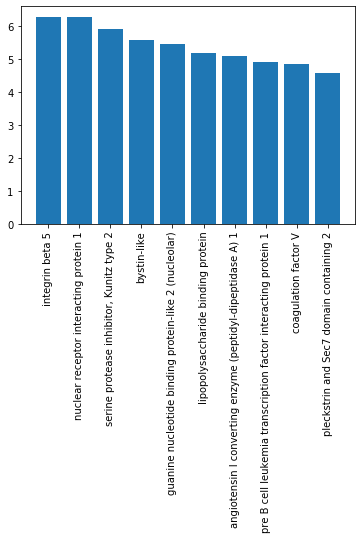

In [15]:
top_ten_fold=list(mouse_differential['fold-change'])
top_ten_num=[]
for i in range(10):
    top_ten_num.append(float(top_ten_fold[i]))
top_ten_names=list(mouse_differential['gene-name'])[:10]
plt.bar(np.arange(10),top_ten_num)
plt.xticks(np.arange(10), top_ten_names)
plt.xticks(rotation='vertical')


In [16]:
print('The top 10 most active genes in Basolateral amygdalar nucleus comparing to Lateral amygdalar nucleus are ' + str(top_ten_names))

The top 10 most active genes in Basolateral amygdalar nucleus comparing to Lateral amygdalar nucleus are ['integrin beta 5', 'nuclear receptor interacting protein 1', 'serine protease inhibitor, Kunitz type 2', 'bystin-like', 'guanine nucleotide binding protein-like 2 (nucleolar)', 'lipopolysaccharide binding protein', 'angiotensin I converting enzyme (peptidyl-dipeptidase A) 1', 'pre B cell leukemia transcription factor interacting protein 1', 'coagulation factor V', 'pleckstrin and Sec7 domain containing 2']


Top 10 most active genes in Lateral amygdalar nucleus comparing to Basolateral amygdalar nucleus

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

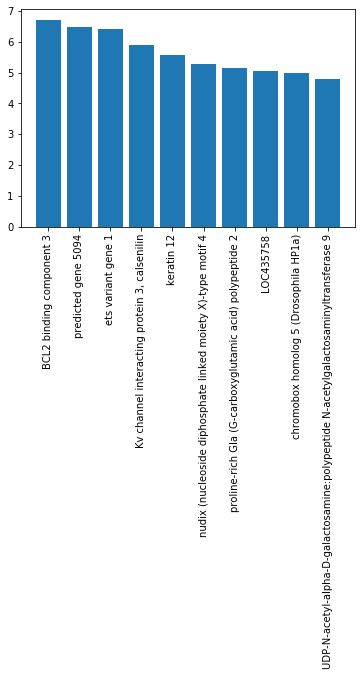

In [7]:
top_ten_fold_LA=list(mouse_differential_LA_BLA['fold-change'])
top_ten_num_LA=[]
for i in range(10):
    top_ten_num_LA.append(float(top_ten_fold_LA[i]))
top_ten_names_LA=list(mouse_differential_LA_BLA['gene-name'])[:10]
plt.bar(np.arange(10),top_ten_num_LA)
plt.xticks(np.arange(10), top_ten_names_LA)
plt.xticks(rotation='vertical')

In [17]:
print('The top 10 most active genes in Lateral amygdalar nucleus comparing to Basolateral amygdalar nucleus are ' + str(top_ten_names_LA))

The top 10 most active genes in Lateral amygdalar nucleus comparing to Basolateral amygdalar nucleus are ['BCL2 binding component 3', 'predicted gene 5094', 'ets variant gene 1', 'Kv channel interacting protein 3, calsenilin', 'keratin 12', 'nudix (nucleoside diphosphate linked moiety X)-type motif 4', 'proline-rich Gla (G-carboxyglutamic acid) polypeptide 2', 'LOC435758', 'chromobox homolog 5 (Drosophila HP1a)', 'UDP-N-acetyl-alpha-D-galactosamine:polypeptide N-acetylgalactosaminyltransferase 9']


These two bar plots clearly shows that there are numbers of genes have different degree of expression in Basolateral amygdalar nucleus and lateral amygdalar nucleus. 

In [9]:
# Fold-change values are strings, get values as floats
fold_change = []
ind = 0
for i in mouse_differential['fold-change']:
    fold_change.append(float(i))
    ind += 1
similar = []
greater = []
less = []

for item in fold_change:
    if item < 0.50:
        less.append(item)
    elif item < 1.5:
        similar.append(item)
    else:
        greater.append(item)

percent_less = len(less)/len(fold_change)
percent_similar = len(similar)/len(fold_change)
percent_greater = len(greater)/len(fold_change)

print('% less:   ', percent_less*100, '\n% similar:', percent_similar*100, '\n% greater:', percent_greater*100)

% less:    3.4535923527597907 
% similar: 87.98437660602323 
% greater: 8.562031041216981


Nearly 88% of the genes tested have similar expression in Basolateral amygdalar nucleus and Lateral amygdalar nucleus. However, there are still genes have different degree of expression between these two regions. About 8% of the genes have greater expression in Basolateral amygdalar nucleus then in Lateral amygdalar nucleus.